# Pixel classification on OpenCL-compatible GPUs
APOC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [sklearn](https://scikit-learn.org/stable/).

Let's start with loading an example image and some ground truth:

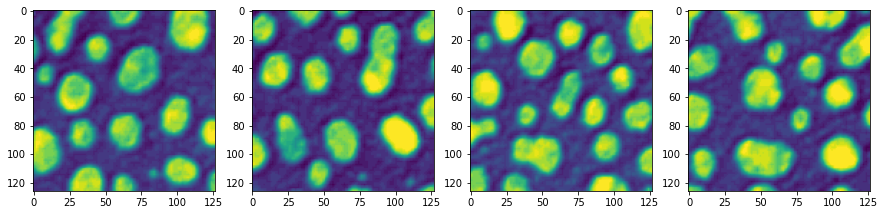

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import apoc
import numpy as np

# load example image
image = imread('blobs.tif')

# cut it into smaller pieces
image1 = image[0:126,0:127]
image2 = image[127:253,0:127]
image3 = image[0:126,128:255]
image4 = image[127:253,128:255]

fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)
axs[3].imshow(image4)

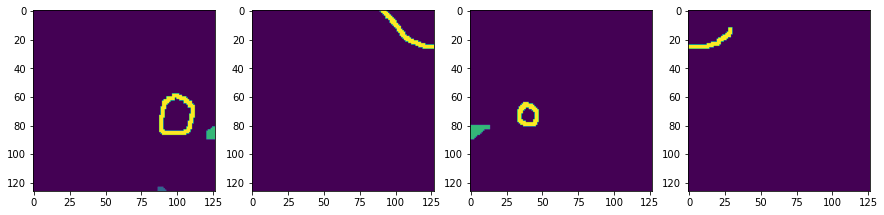

In [2]:
# load mnual annotation
labels = imread('annotations.tif')

# cut it into pieces
labels1 = labels[0:126,0:127]
labels2 = labels[127:253,0:127]
labels3 = labels[0:126,128:255]
labels4 = labels[127:253,128:255]

fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(labels1)
axs[1].imshow(labels2)
axs[2].imshow(labels3)
axs[3].imshow(labels4)

## Training
We now train a OCLRandomForestClassifier, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [3]:
# define features: original image, a blurred version and an edge image
features = "original gaussian_blur=2 sobel_of_gaussian_blur=2"

# this is where the model will be saved
cl_filename = 'my_model.cl'

apoc.erase_classifier(cl_filename)
clf = apoc.PixelClassifier(opencl_filename=cl_filename)
clf.train(features, labels1, image1)

## Prediction
We now predict one of the pieces after training on just one of the pieces

C:\Users\rober\miniconda3\envs\bio1\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


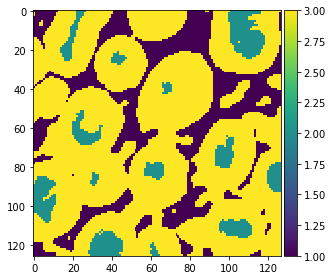

In [4]:
result = clf.predict(image=image1)
imshow(result)

In [5]:
# print how many training data points are there
print(len(clf._y))

333


## Continue training
We now continue training the former classifier. The number of data points in the classifier will increase. It will always be trained on these points.

In [6]:
clf.train(features, labels2, image2, continue_training=True)
# print how many training data points are there
print(len(clf._y))
clf.train(features, labels3, image3, continue_training=True)
# print how many training data points are there
print(len(clf._y))
clf.train(features, labels4, image4, continue_training=True)
# print how many training data points are there
print(len(clf._y))

500
734
856


C:\Users\rober\miniconda3\envs\bio1\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


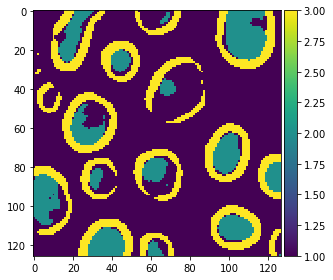

In [7]:
# Show result of the same tile as above, but after training on all tiles
result = clf.predict(image=image1)
imshow(result)

In [8]:
# Quality assurance: We now check if the result is at least similar 
# compared to processing the whole image in one shot.
# assemble image
result1 = clf.predict(image=image1)
result2 = clf.predict(image=image2)
result3 = clf.predict(image=image3)
result4 = clf.predict(image=image4)

result_stichted = np.concatenate((np.concatenate((result1, result2),0), np.concatenate((result3, result4),0)), 1)

In [9]:
clf = apoc.PixelClassifier(opencl_filename=cl_filename)
clf.train(features, labels, image)

result = clf.predict(image=image)

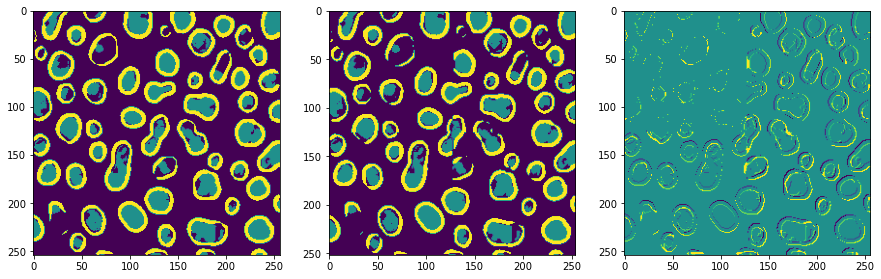

In [10]:
difference = result - result_stichted


fig, axs = plt.subplots(1, 3, figsize=(15,15))
axs[0].imshow(result)
axs[1].imshow(result_stichted)
axs[2].imshow(difference)
